## Surface wave dispersion inversion using Metropolis-Hastings

This notebook shows examples using Monte Carlo sampling method to solve surface wave dispersion inversion problem. We 
use Monte Carlo implementation of PyMC3 (https://docs.pymc.io/). So first load PyMC3 and some useful modules.

In [1]:
%matplotlib notebook
import pymc3 as pm
import theano
import theano.tensor as tt

from time import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Synthetic test

We create a simple synthetic example which consists of 10 layers.

In [2]:
# Load dispersion modelling code
from pydisp import disp

In [3]:
thk = np.full((10),fill_value=0.1)
thk[-1]=0; # set the thickness of last layer to be 0 to represent half space
vs = np.zeros_like(thk)
vs = np.array([0.4,0.5,0.6,0.6,0.6,0.8,0.85,0.9,1.0,1.0])

# vp and density are calculate from shear velocity using experience relationships
vp = 1.16*vs + 1.36
rho = 1.74*vp**0.25
if(vs[0]<1e-4):
    vp[0] = 1.5
    rho[0] = 1.0

In [4]:
period = np.linspace(0.7,2.0,14) # set period range
# It is better to calculate phase velocity on evenly-spaced periods than evenly-spaced frequencies
freqs = 1./period;

# using disp to calculate phase velocity dispersion curve
# some arguments:
# modetype: 1 for Rayleigh wave, 0 for Love wave
# phasetype: 1 for group velocity, 0 for phase velocity
# dc: spacing of phase velocity which is used to search phase velocity
phase = disp(thk,vp,vs,rho,freqs,modetype=1,phasetype=0,dc=5e-4)
print(phase)

[0.45015499 0.47008654 0.48836651 0.50459647 0.51926571 0.53319633
 0.54716855 0.56181628 0.5776332  0.59499264 0.61413699 0.63513875
 0.65783066 0.68173689]


<IPython.core.display.Javascript object>


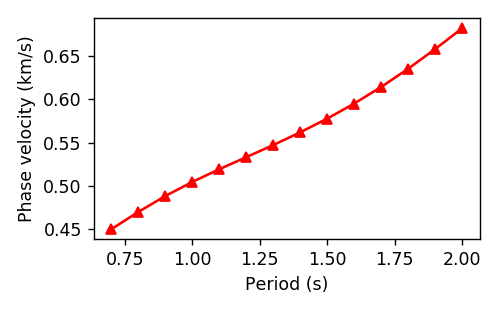

In [5]:
plt.figure(figsize=(4,2.5))
plt.plot(period,phase,'r^-',label='phase velocity')
plt.xlabel('Period (s)'); plt.ylabel('Phase velocity (km/s)')
plt.tight_layout()

### Monte Carlo sampling using PyMC3

In order to use PyMC3, we need to create a theano operator for our own likelihood function.
In this way we can use any function in the framework of PyMC3.

In [6]:
class loglike(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dscalar]
    
    def __init__(self, model, freqs, data, thick, sigma=0.003, waterlayer=0, mode=1, ptype=0, dc=1e-3):
        self.model = model
        self.freqs = freqs
        self.data = data
        self.thick = thick
        self.sigma = sigma
        self.waterlayer = waterlayer # can have a water layer at the top
        self.mode = mode
        self.ptype = ptype
        self.dc = dc
        
    def perform(self, node, inputs, outputs):
        theta, = inputs
        vs = np.copy(theta)
        vp = 1.16*theta + 1.36
        rho = 1.74*vp**0.25
        if(self.waterlayer==1):
            vs=np.insert(vs,0,0.0)
            vp=np.insert(vp,0,1.5)
            rho=np.insert(rho,0,1.0)
            
        # set a prior information: the top layer has minimum shear-velocity
        # This ensures the computed phase velocities are phase velocities of Rayleigh or Love waves         
        if(self.waterlayer==0 and any(vs[1:]<vs[0])
          or self.waterlayer==1 and any(vs[2:]<vs[1])):
            lglike = -np.inf
        else:
            phase = self.model(self.thick,vp,vs,rho,self.freqs,self.mode,self.ptype,self.dc)
            lglike = -(0.5/self.sigma**2)*np.sum((self.data-phase)**2)
            if(all(phase==0)): # failed to find solutions, set lglike to -infinite
                lglike=-np.inf

        outputs[0][0] = np.array(lglike)

Create a model using above likelihood function. We set prior pdfs to be Uniform distributions for each layer.

In [7]:
data = phase + 0.02*phase*np.random.normal(size=phase.shape) # add 2 percent noise
logl = loglike(disp, freqs, phase, thk, waterlayer=0)
with pm.Model() as model:
    v1 = pm.Uniform('v1',lower=0.33,upper=0.63,shape=(1,))
    v2 = pm.Uniform('v2',lower=0.43,upper=0.79,shape=(1,))
    v3 = pm.Uniform('v3',lower=0.48,upper=0.88,shape=(1,))
    v4 = pm.Uniform('v4',lower=0.51,upper=0.95,shape=(1,))
    v5 = pm.Uniform('v5',lower=0.55,upper=1.05,shape=(1,))
    v6 = pm.Uniform('v6',lower=0.6,upper=1.2,shape=(1,))
    v7 = pm.Uniform('v7',lower=0.58,upper=1.28,shape=(1,))
    v8 = pm.Uniform('v8',lower=0.56,upper=1.36,shape=(1,))
    v9 = pm.Uniform('v9',lower=0.56,upper=1.36,shape=(1,))
    v10 = pm.Uniform('v10',lower=0.6,upper=1.4,shape=(1,))
    theta = pm.math.concatenate([v1,v2,v3,v4,v5,v6,v7,v8,v9,v10],axis=0)
    print(theta.shape)
    pm.DensityDist('likelihood',lambda v: logl(v), observed={'v': theta})

Shape.0


Using Metropolis-Hastings method to sample the posterior distribution. We use 2 chains each of which
contains 60,000 samples with a burn-in period of 10,000.

In [8]:
ndraws = 50000; nburn = 10000
with model:
    trace = pm.sample(ndraws, step=pm.Metropolis(tune_inverval=100), 
                      tune=nburn, discard_tuned_samples=True, cores=3, chains=3)

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [v10]
>Metropolis: [v9]
>Metropolis: [v8]
>Metropolis: [v7]
>Metropolis: [v6]
>Metropolis: [v5]
>Metropolis: [v4]
>Metropolis: [v3]
>Metropolis: [v2]
>Metropolis: [v1]
Sampling 3 chains: 100%|██████████| 180000/180000 [32:22<00:00, 92.68draws/s] 
The estimated number of effective samples is smaller than 200 for some parameters.


In [9]:
samples = np.concatenate((trace['v1'],trace['v2'],trace['v3'],trace['v4'],trace['v5'],
                    trace['v6'],trace['v7'],trace['v8'],trace['v9'],trace['v10']),axis=1)
mean = np.mean(samples,axis=0)

<IPython.core.display.Javascript object>


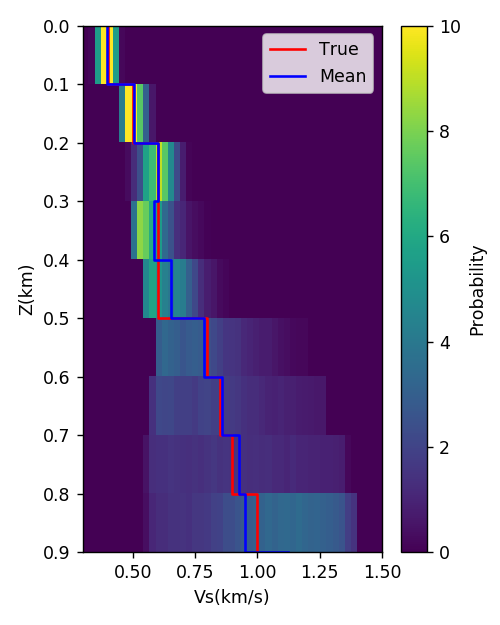

In [10]:
zd = np.cumsum(thk)-0.1; zd[-1]=0.9;
z=zd;
zd = np.tile(zd,samples.shape[0])
xd = samples.flatten()
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(4,5))
x_edges = np.linspace(0.3,1.5,50)
y_edges = z
h, xedges, yedges, _=plt.hist2d(xd,zd,bins=[x_edges,y_edges],density=True,vmin=0,vmax=10)
plt.step(vs,z,'r-',label='True')
plt.step(mean,z,'b-',label='Mean')
plt.legend()
plt.gca().invert_yaxis()
ax.set_xlim(0.3,1.5)
plt.xlabel('Vs(km/s)'); plt.ylabel('Z(km)')
cb=plt.colorbar(); cb.ax.set_ylabel('Probability')
plt.tight_layout()